# Yongjie's CA2-Stock Price Forecasting

Name: Li Yongjie

ID: 2342377

Class: DAAA/FT/1B/01

## Objective
Train time series models and forecast the stock price
of Apple, Amazon and DBS for the next 60 days

<hr>

## Importing Necassary Libraries
<hr>


In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from tqdm import tqdm

# Metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX

# EDA + Model Selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings("ignore")


sns.set_theme(palette='bright')
# Set the style for plots
plt.style.use('seaborn-v0_8-darkgrid')


<hr>

## Loading Dataset
<hr>

In [2]:
# Load the dataset
df = pd.read_csv("./CA2-Stock-Price-Data.csv")

# Set Date as index
df["Date"] = pd.to_datetime(df["Date"])

df.set_index("Date", inplace=True)

df

,Apple,Amazon,DBS
Date,,,
2018-10-01,56.814999,100.218002,25.969999
2018-10-02,57.320000,98.565498,25.629999
2018-10-03,58.017502,97.638000,25.950001
2018-10-04,56.997501,95.471001,25.760000
2018-10-05,56.072498,94.482498,25.770000
...,...,...,...
2023-09-22,174.789993,129.119995,33.250000
2023-09-25,176.080002,131.270004,33.450001
2023-09-26,171.960007,125.980003,33.509998


<hr>

## Exploratory Data Analysis
<hr>

Now we will conduct and exploratory data analysis of the dataset to gain a better understanding of the dataset. We will be trying to find

In [3]:
df_eda = df.copy()

In [4]:
df_eda.describe()

,Apple,Amazon,DBS
count,1257.000000,1257.000000,1257.000000
mean,116.168385,124.791237,28.185863
std,46.945568,32.495925,4.738732
min,35.547501,67.197998,16.879999
25%,66.592499,93.489998,24.879999
50%,129.610001,120.970001,28.650000
75%,152.589996,158.100494,32.480000
max,196.449997,186.570496,37.250000


In [5]:
df_eda.shape

(1257, 3)

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2018-10-01 to 2023-09-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 39.3 KB


In [7]:
df_eda.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

In [8]:
df.index

DatetimeIndex(['2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08', '2018-10-09', '2018-10-10',
               '2018-10-11', '2018-10-12',
               ...
               '2023-09-15', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28'],
              dtype='datetime64[ns]', name='Date', length=1257, freq=None)

In [9]:
pd.date_range(start = '2018-10-01', end = '2023-09-28', freq='D').difference(df.index)

DatetimeIndex(['2018-10-06', '2018-10-07', '2018-10-13', '2018-10-14',
               '2018-10-20', '2018-10-21', '2018-10-27', '2018-10-28',
               '2018-11-03', '2018-11-04',
               ...
               '2023-08-27', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-09', '2023-09-10', '2023-09-16', '2023-09-17',
               '2023-09-23', '2023-09-24'],
              dtype='datetime64[ns]', length=567, freq=None)

<hr>

## Visualising the dataset
<hr>

In [10]:
colors = ['#fe4a49', '#2ab7ca', '#fed766']

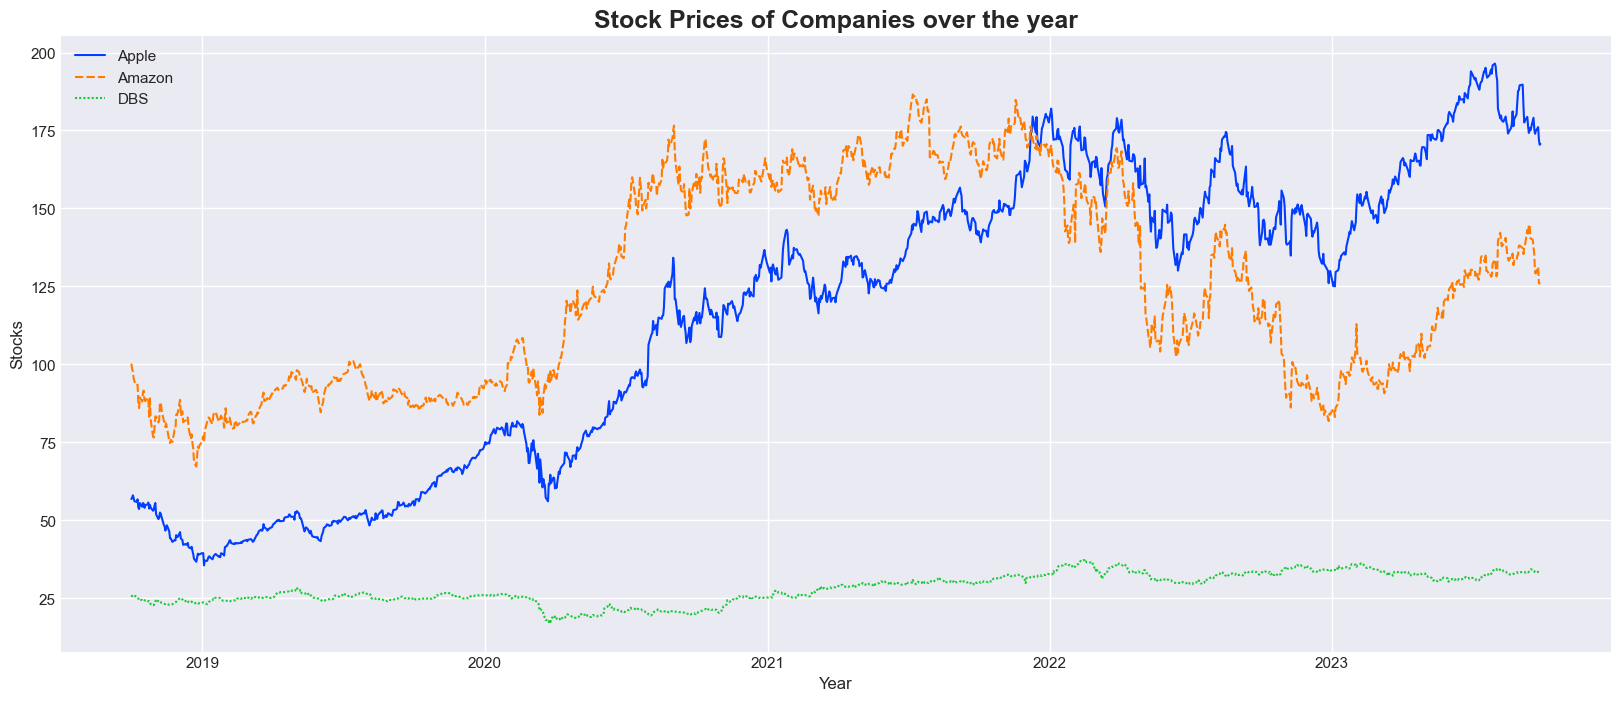

In [11]:
plt.figure(figsize=(20,8))

sns.lineplot(df_eda)

plt.xlabel('Year')
plt.ylabel('Stocks')
plt.title(f'Stock Prices of Companies over the year', fontweight='bold', fontsize=18)

plt.show()

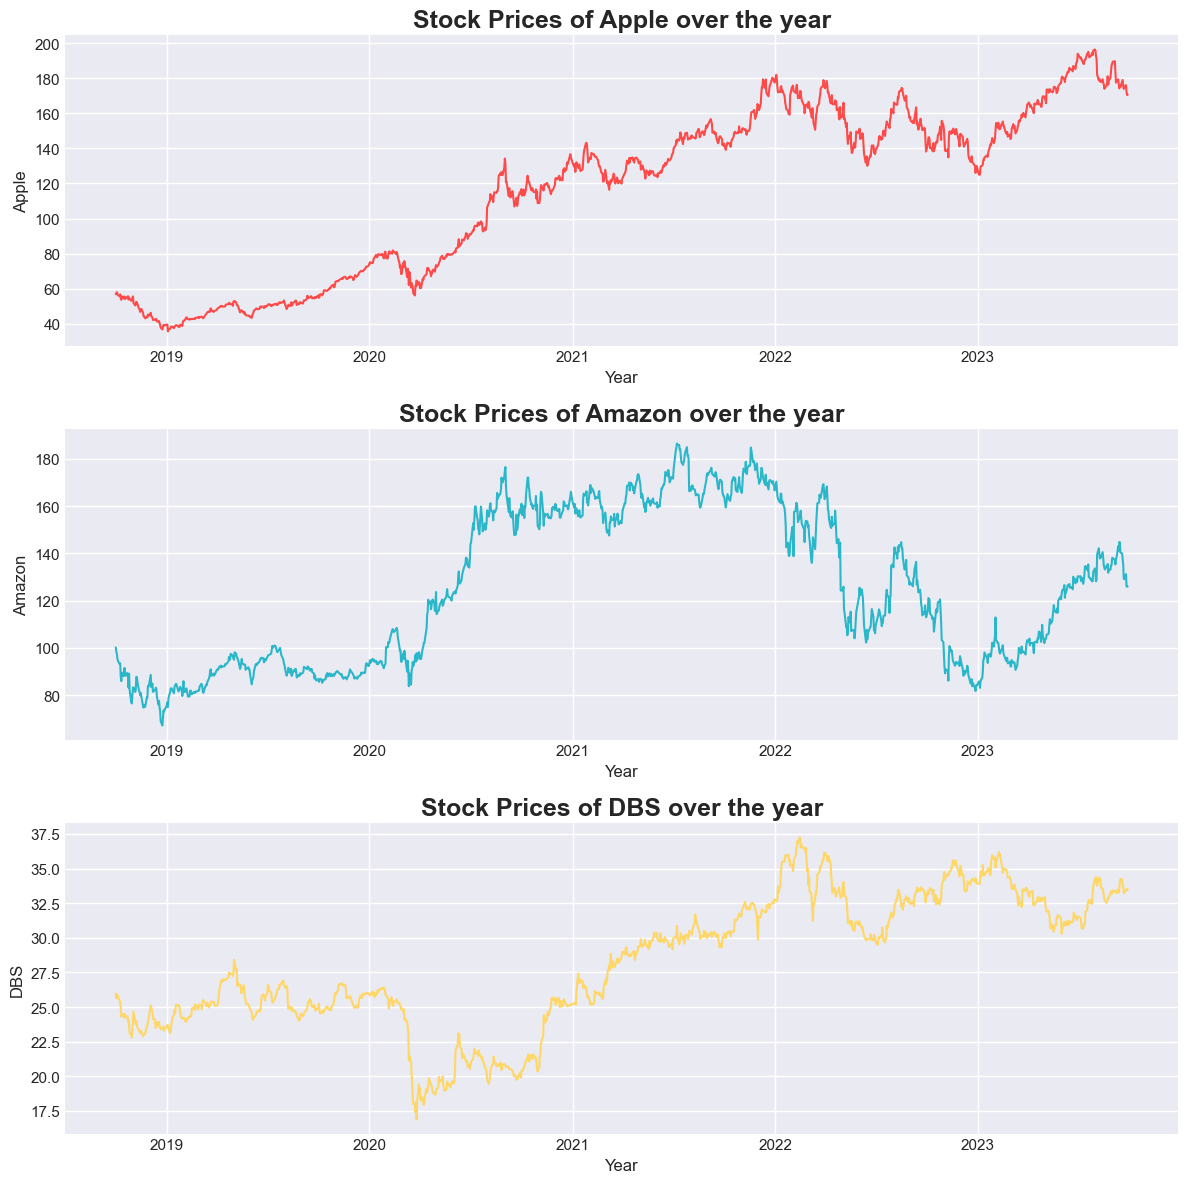

In [12]:
# Set the figure size
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

for i, (col, color) in enumerate(zip(df_eda.columns, colors)):
    sns.lineplot(data=df_eda, y=col,x=df_eda.index, ax=ax[i], color=colors[i])

    # # Add labels and title
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel(col)
    ax[i].set_title(f'Stock Prices of {col} over the year', fontweight='bold', fontsize=18)


# Show the plot
plt.tight_layout()
plt.show()


<u>Observations</u>

<hr>

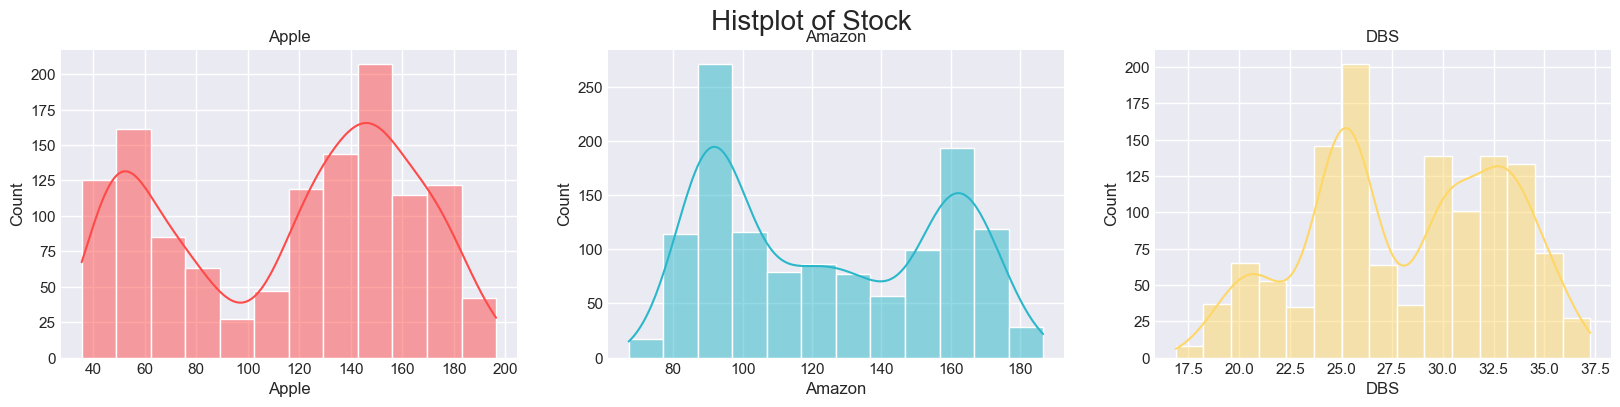

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Enumerate over columns and plot histograms
for i, (col, color) in enumerate(zip(df_eda.columns, colors)):
    sns.histplot(data=df_eda, x=col, ax=ax[i], kde=True, color=color)
    ax[i].set_title(col)  # Set subplot title

# Set figure title
plt.suptitle('Histplot of Stock', fontsize=20)

# Show plot
plt.show()


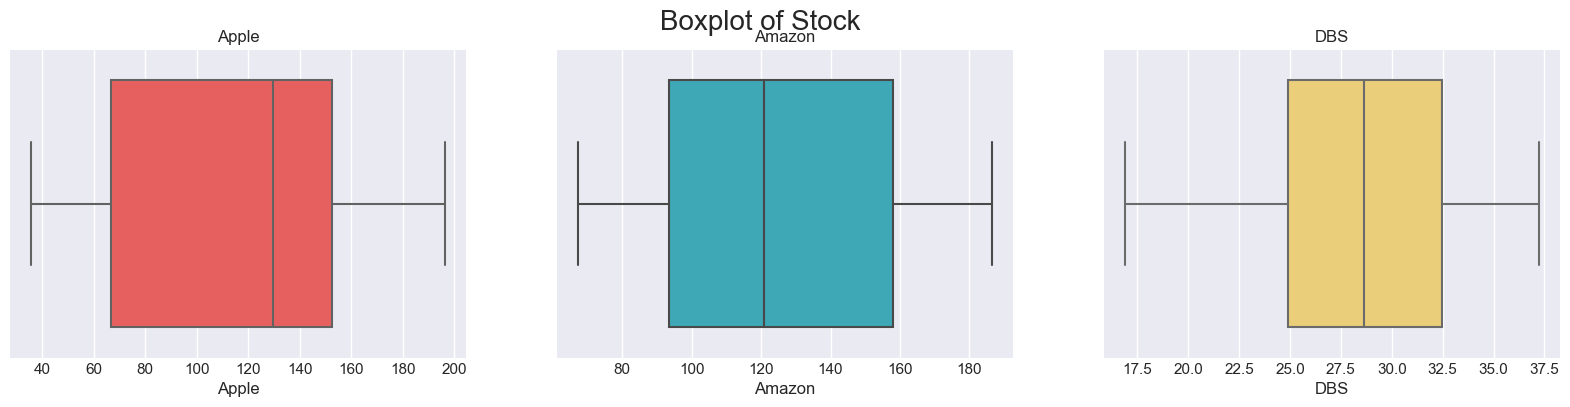

In [14]:
# Boxplots
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, (col, color) in enumerate(zip(df_eda.columns, colors)):
    sns.boxplot(data=df_eda, x=col, ax=ax[i], color=color)
    ax[i].set_title(col)  # Set subplot title

    
plt.suptitle('Boxplot of Stock', fontsize=20)
plt.show()

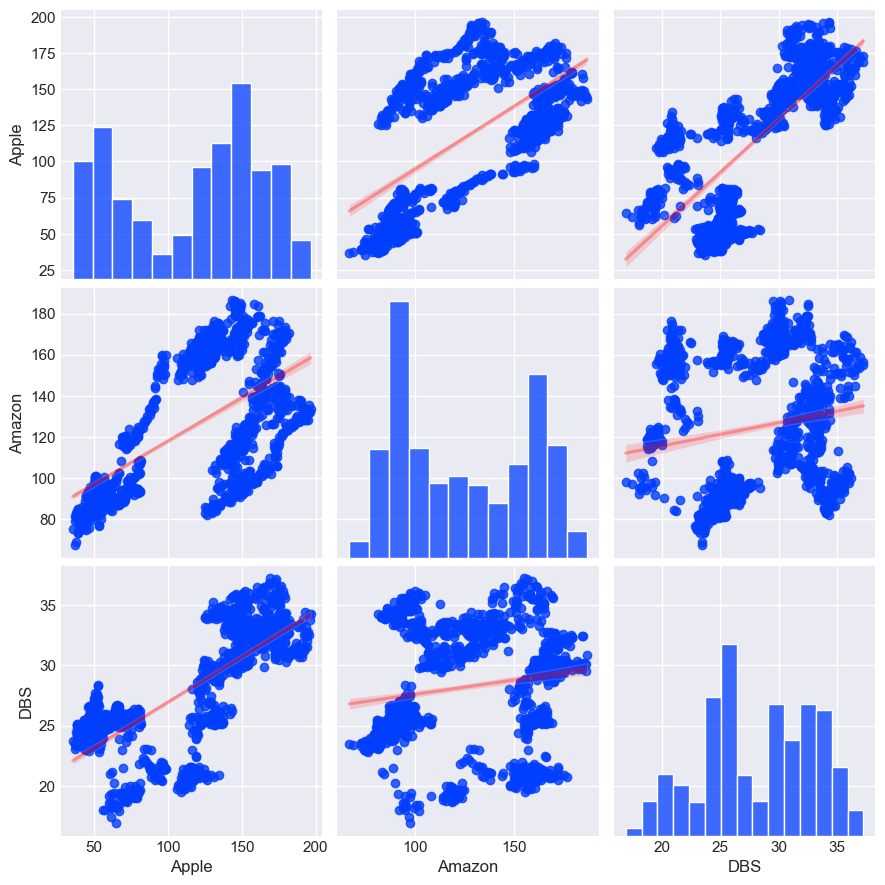

In [15]:
# Pairplot
sns.pairplot(df_eda, kind='reg', plot_kws={'line_kws':{'color':'red','alpha':0.3}},height=3)
plt.show()

<hr>

### Time Series Analysis
<hr>

Seasonal Decomposition
Column: Apple
Seasonal 7


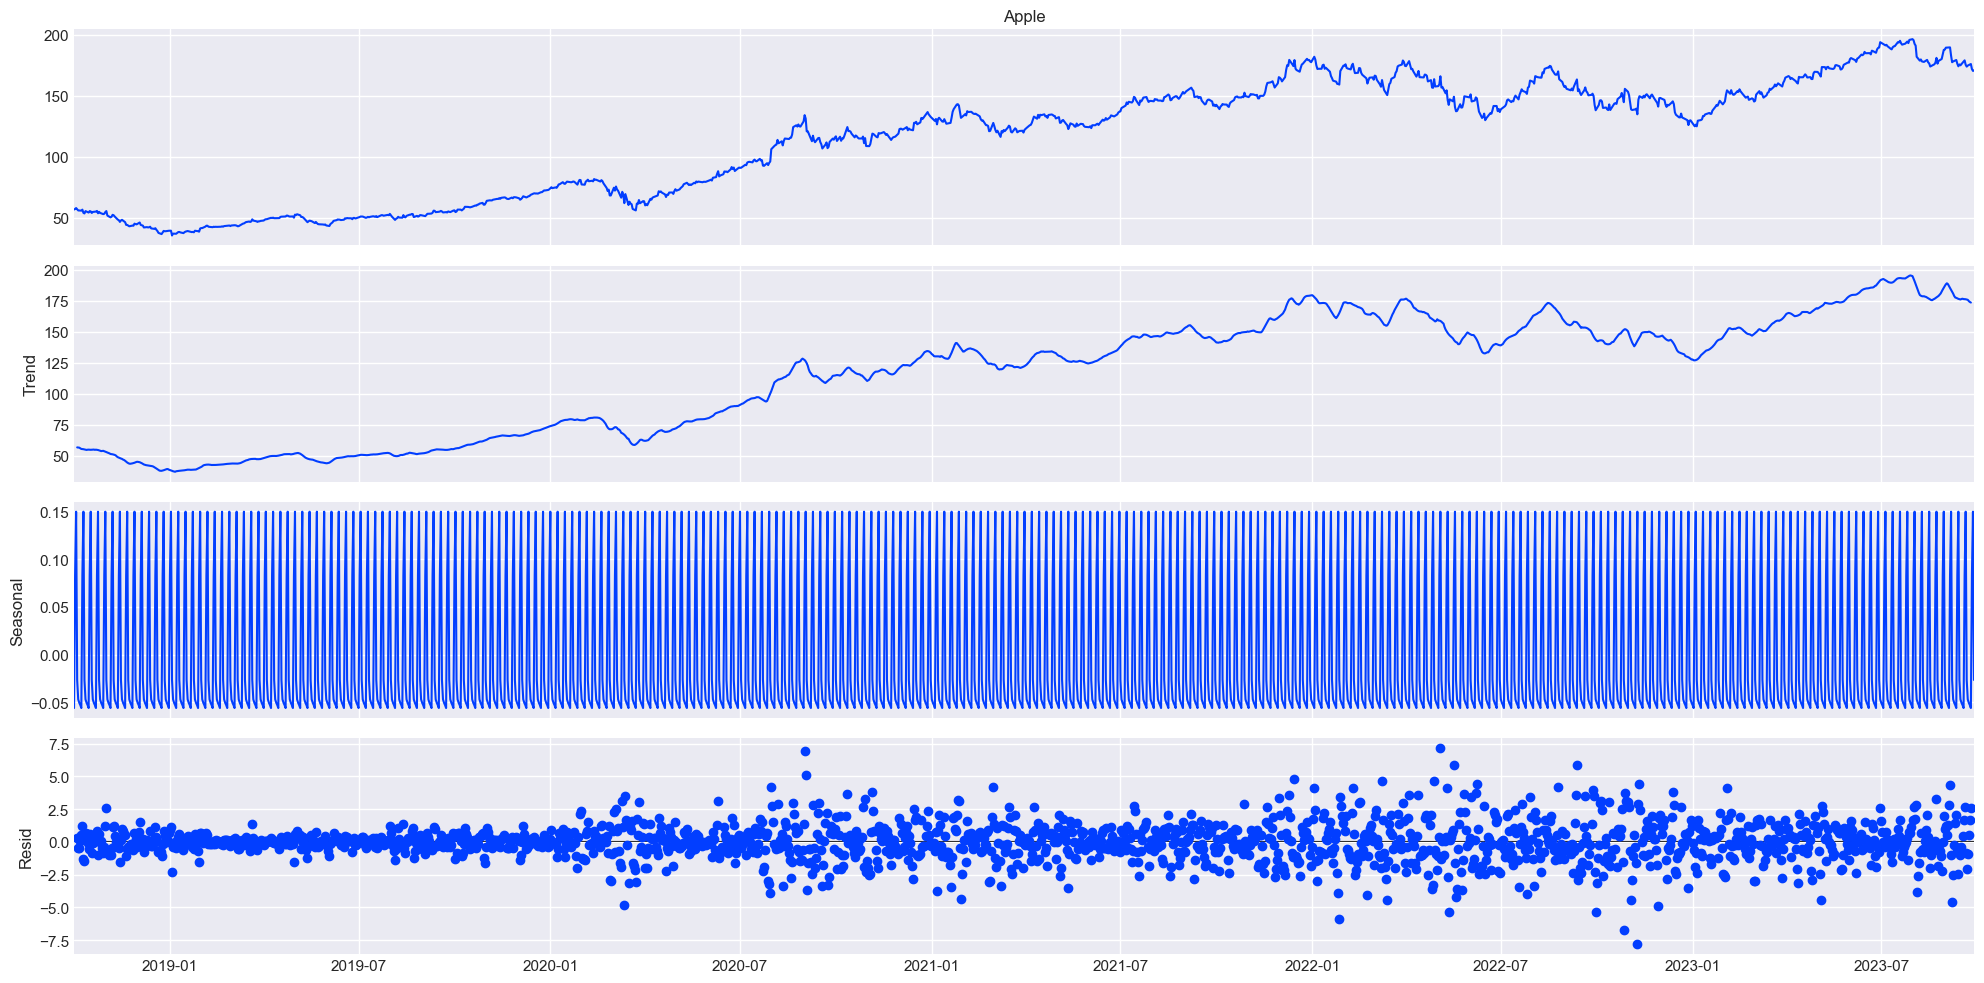

Seasonal Decomposition
Column: Amazon
Seasonal 7


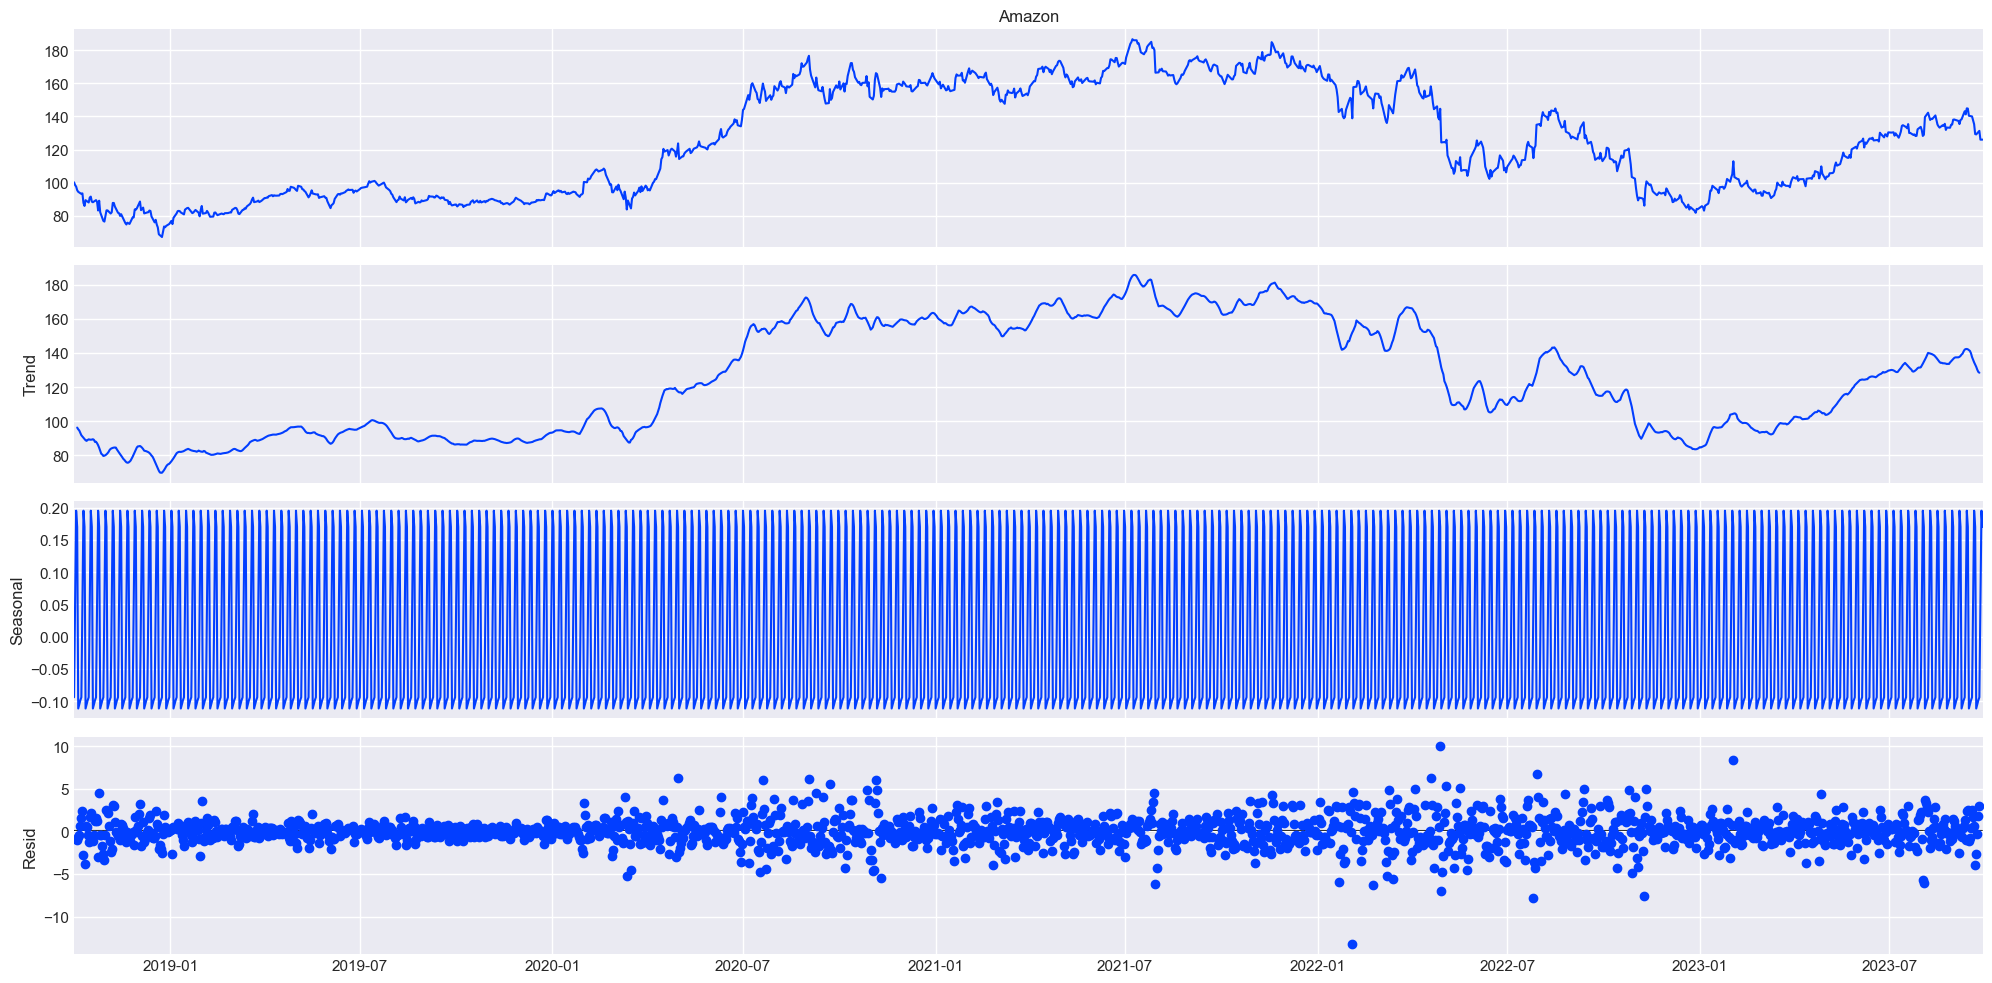

Seasonal Decomposition
Column: DBS
Seasonal 7


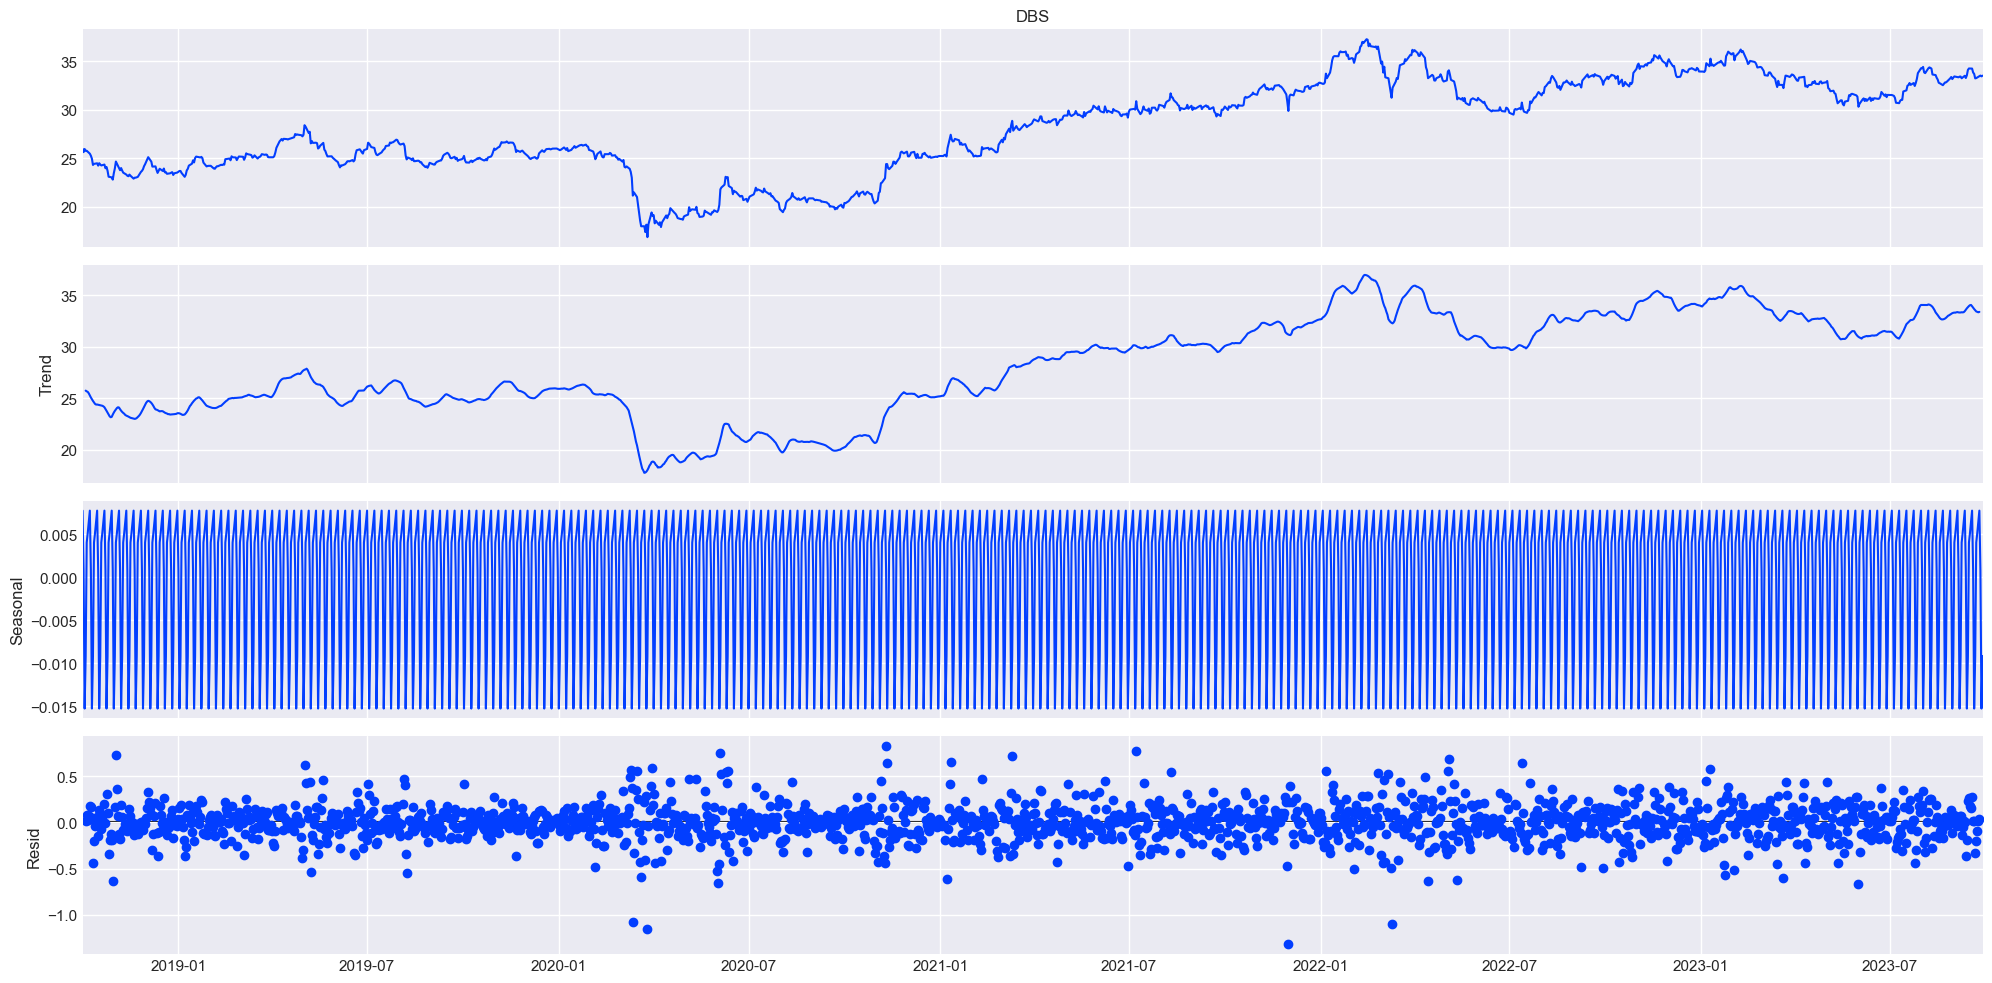

In [16]:
df = df.asfreq('D')
df = df.interpolate()

for i in df.columns:
    plt.rc("figure", figsize=(20, 10))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(df[i], model='additive')
    print("Seasonal", len(decomposition.seasonal.drop_duplicates()))
    decomposition.plot()
    plt.show()

## Check for stationary or non-stationary series using ACF Plot

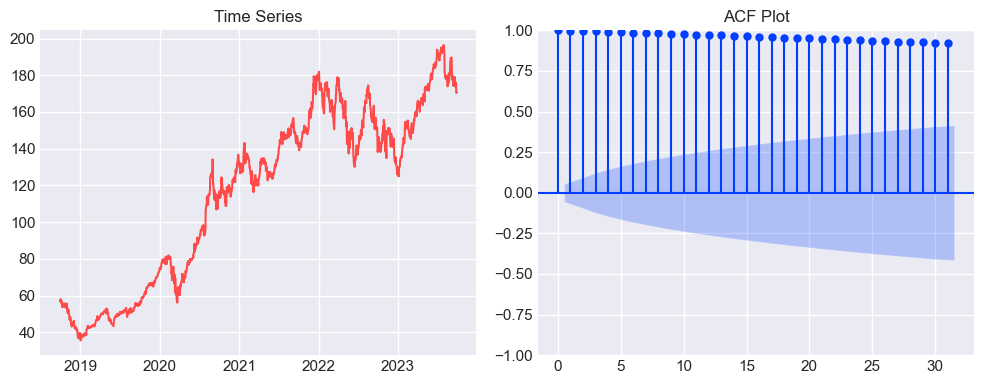

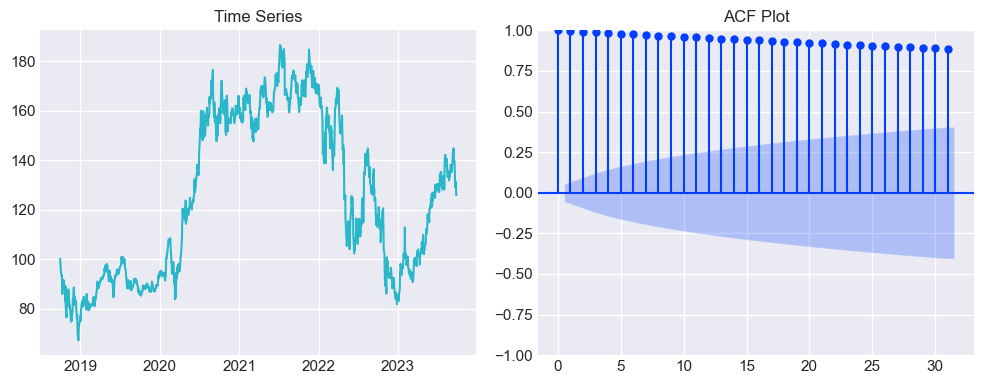

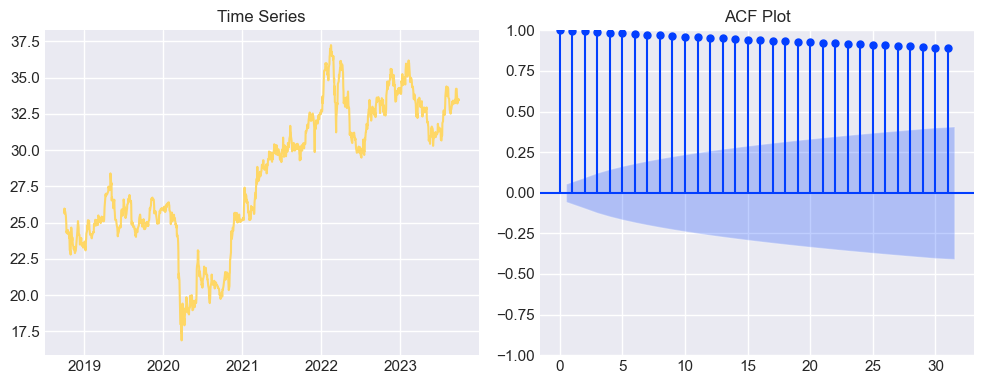

In [17]:
for i, col in enumerate(df.columns):
    # Create the line plot with style, colors, and labels
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the time series series data
    axs[0].plot(df_eda[col], color=colors[i])
    axs[0].set_title('Time Series')

    # Plot the autocorrelation function
    plot_acf(df_eda[col], ax=axs[1], title='ACF Plot')

    plt.tight_layout()
    plt.show()

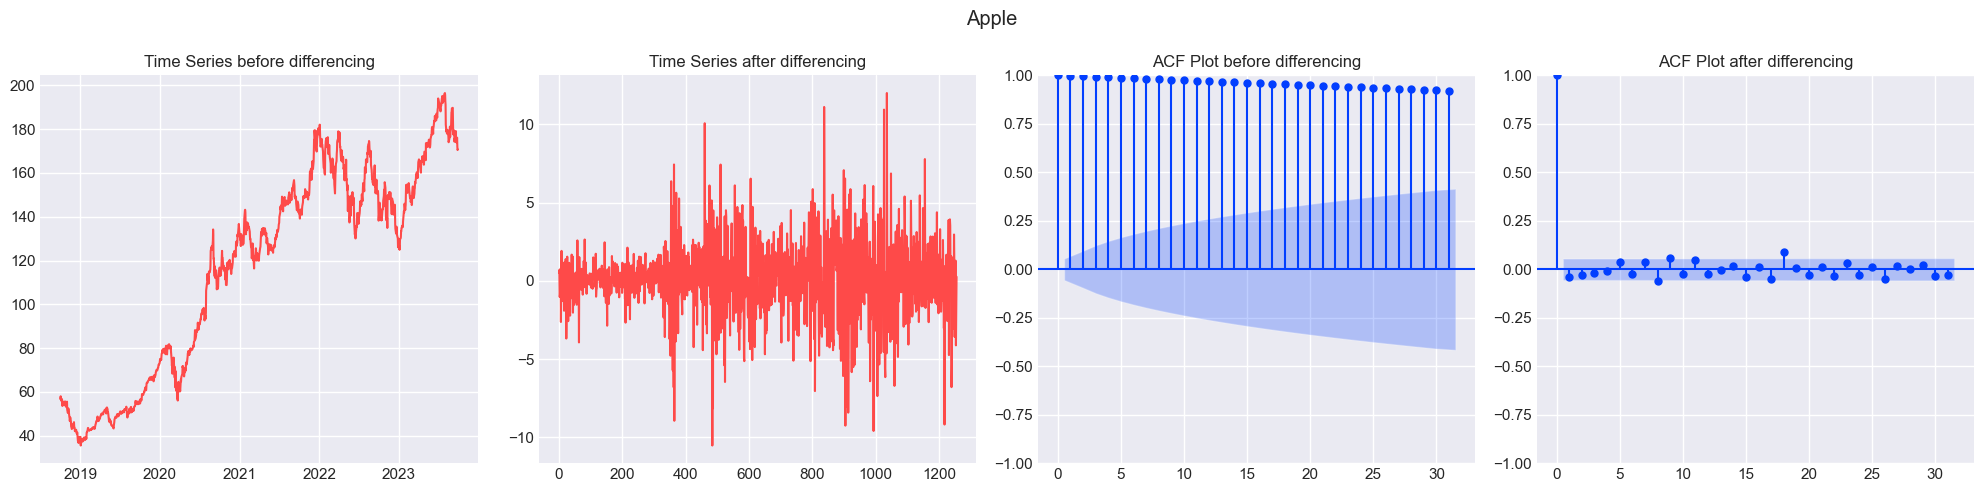

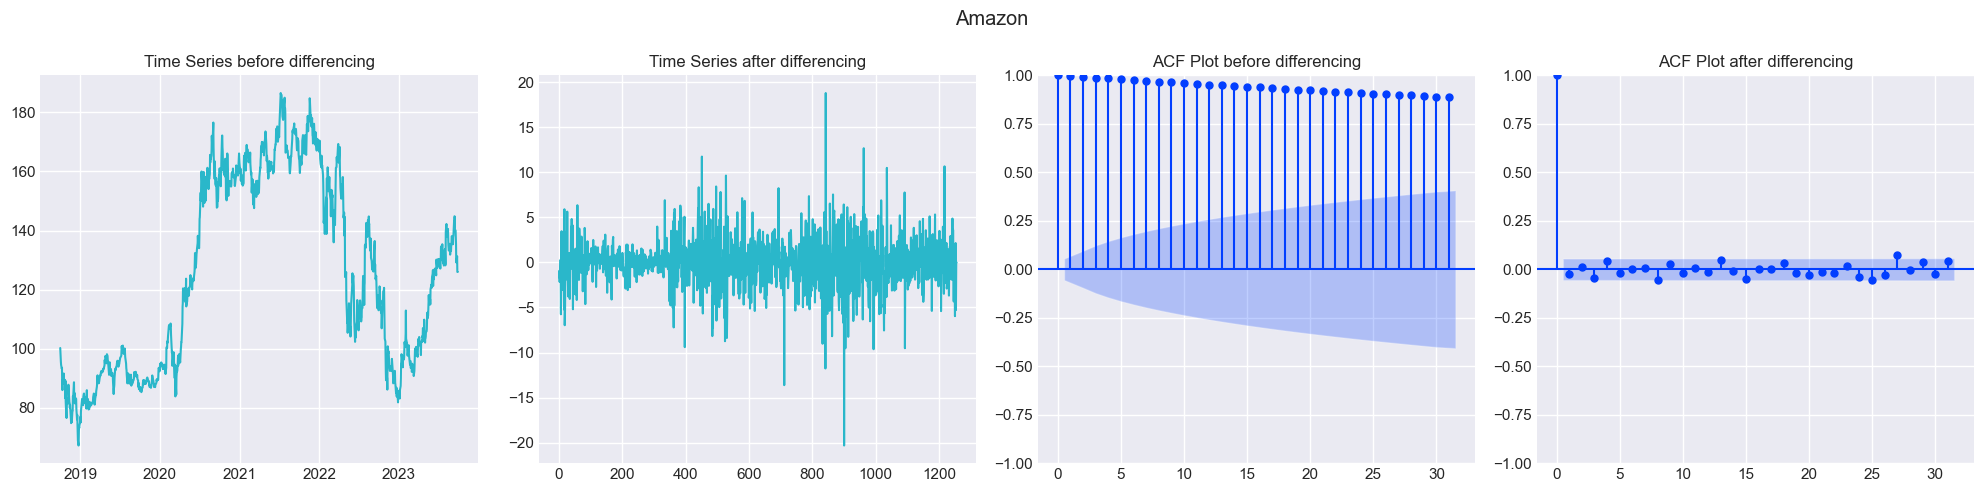

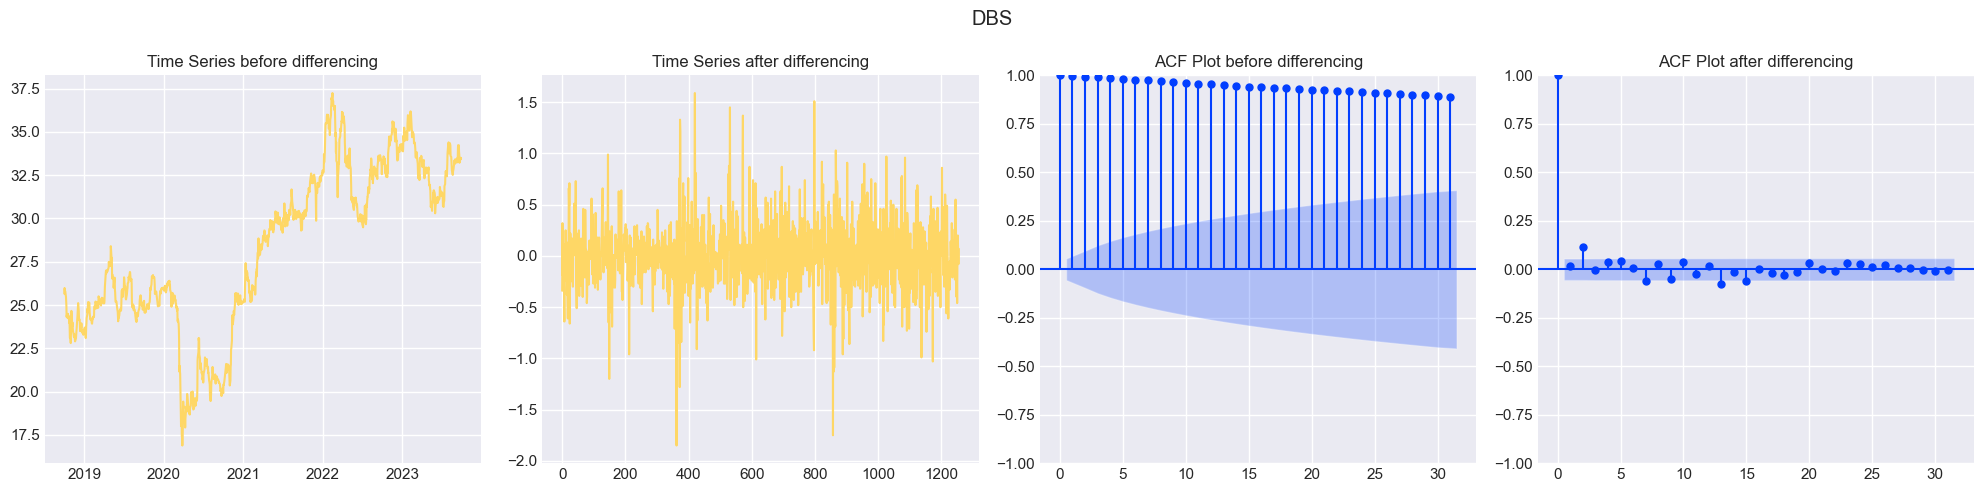

In [18]:
for i, col in enumerate(df.columns):
    # Create the line plot with style, colors, and labels
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot the time series series data
    axs[0].plot(df_eda[col], color=colors[i])
    axs[0].set_title('Time Series before differencing')

    # Plot the autocorrelation function
    plot_acf(df_eda[col], ax=axs[2], title='ACF Plot before differencing')

    # Get the differenced
    x_diff = np.diff(df_eda[col], n=1)

    # Plot the time series series data
    axs[1].plot(x_diff, color=colors[i])
    axs[1].set_title('Time Series after differencing')

    # Plot the autocorrelation function
    plot_acf(x_diff, ax=axs[3], title='ACF Plot after differencing')

    plt.suptitle(f'{col}')
    plt.tight_layout()
    plt.show()

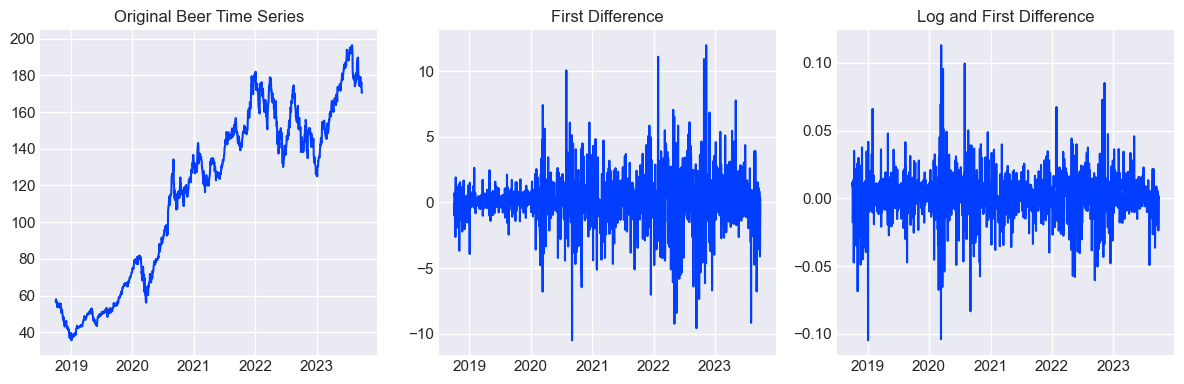

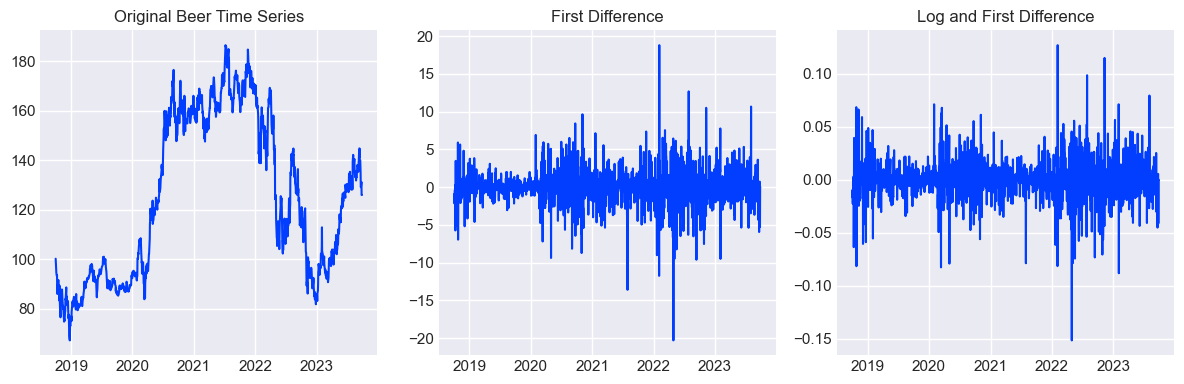

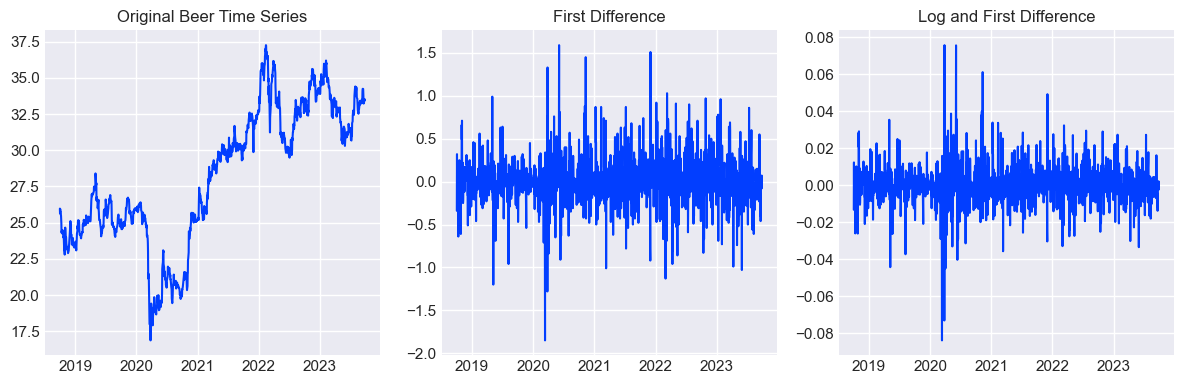

In [19]:
for col in df.columns:
    # Check if the series is stationary and transform the series if they are not
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(df[col])
    plt.title('Original Beer Time Series')

    plt.subplot(1, 3, 2)
    plt.plot(df[col].diff())
    plt.title('First Difference')

    plt.subplot(1, 3, 3)
    plt.plot(np.log(df[col]).diff())
    plt.title('Log and First Difference')

    plt.tight_layout()
    plt.show()

## Applying differncing to convert to Stationary Series

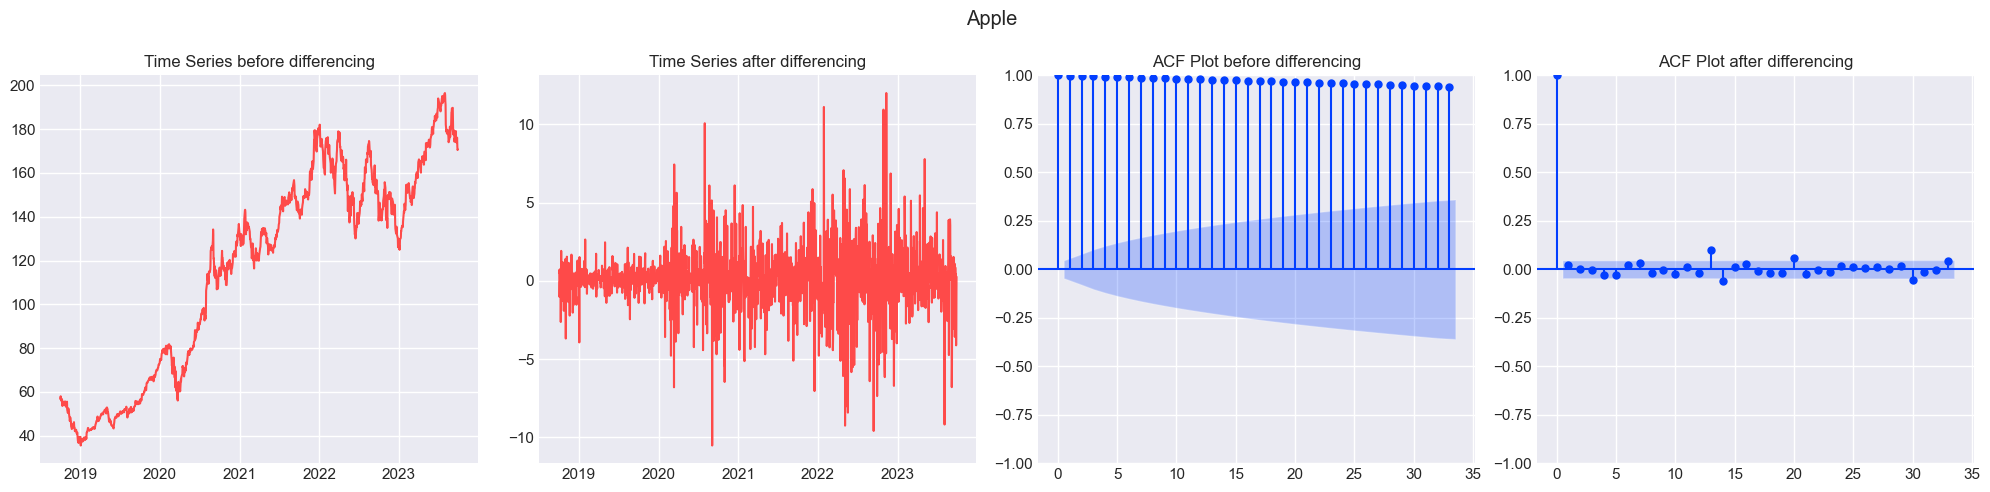

p-value original: 0.7650692611897276
p value after differencing: 8.479066869455394e-21

- H0: the series is non stationary
- H1: the series is stationary
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.00

After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)
************************************************************


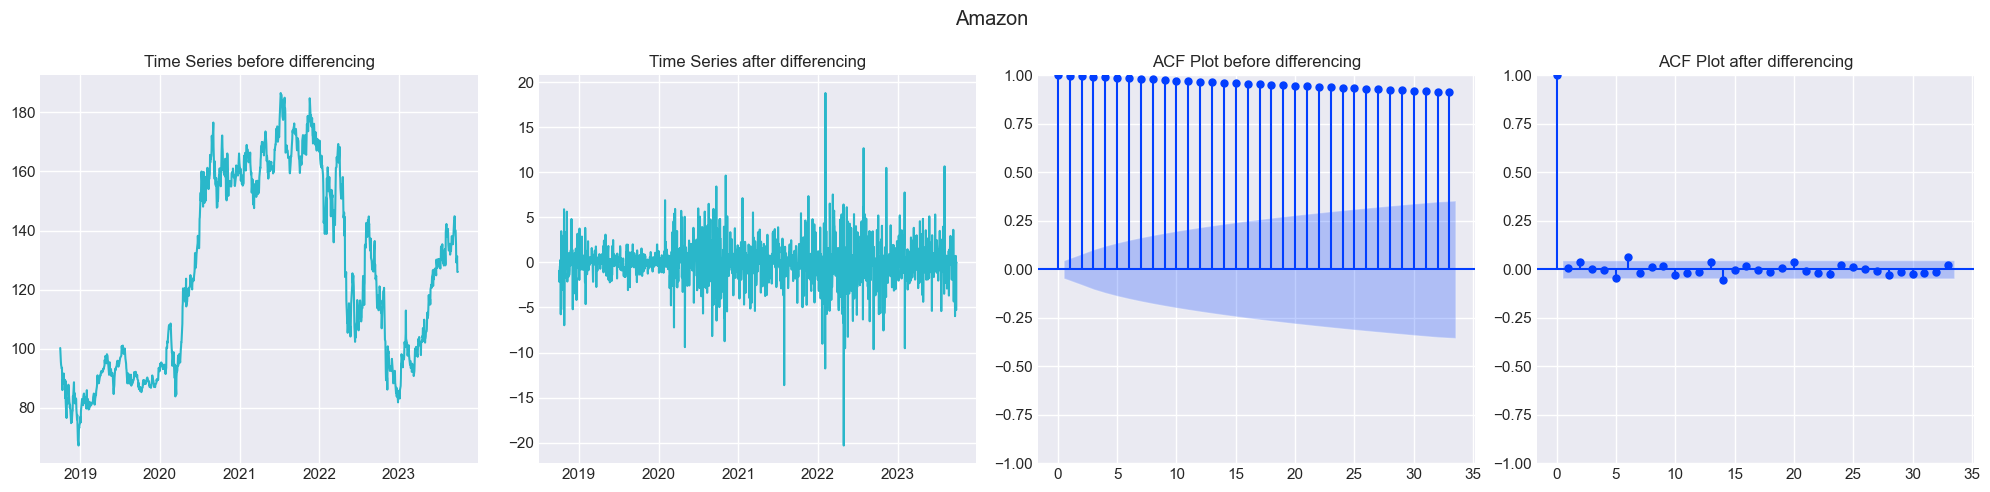

p-value original: 0.4586527645365144
p value after differencing: 1.2604263689402116e-29

- H0: the series is non stationary
- H1: the series is stationary
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.08

After differencing, the series's autocorrelation is zero (i.e. has no autocorrelations) as p-value >= 0.05 (fail to reject H0)
************************************************************


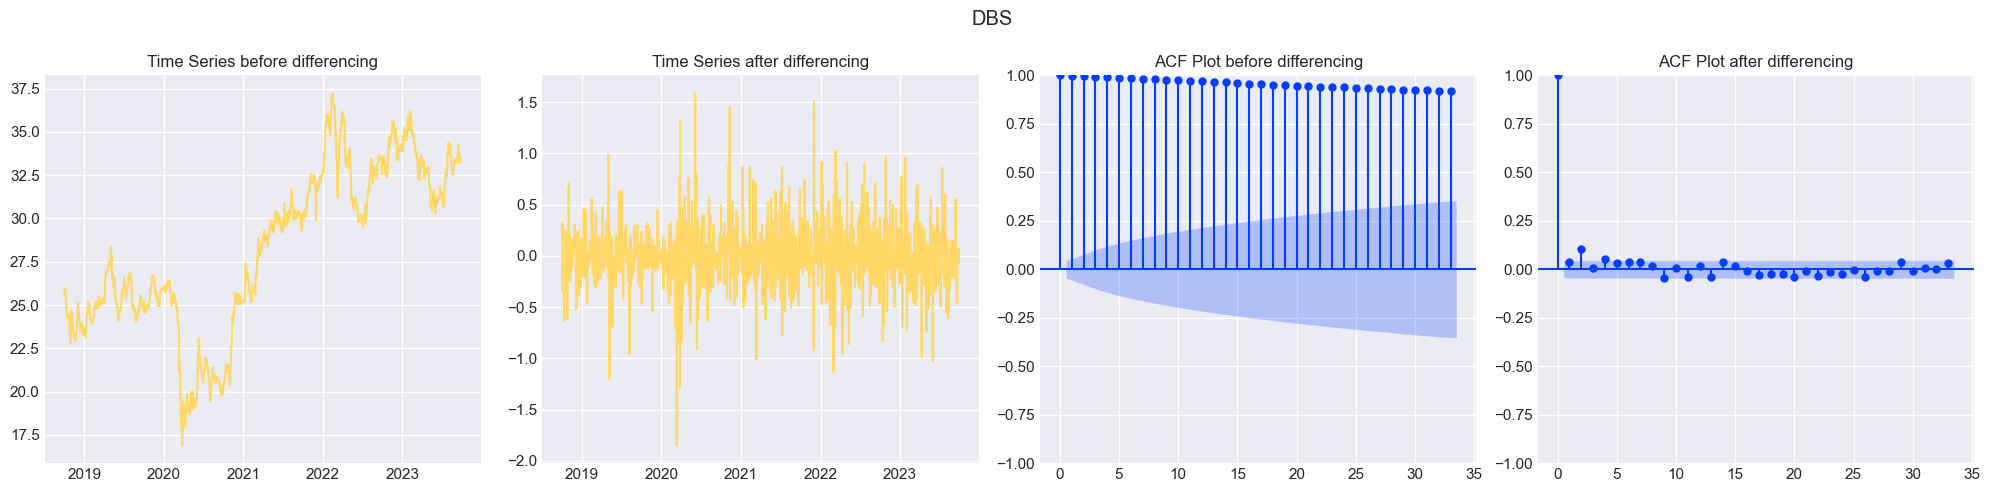

p-value original: 0.6556796201732035
p value after differencing: 0.0

- H0: the series is non stationary
- H1: the series is stationary
After differencing, the series becomes stationary (p<=0.05)

p-value of Ljung-Box Test Before differencing: 0.0
p-value of Ljung-Box Test After differencing: 0.00

After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)
************************************************************


In [20]:
for i, col in enumerate(df.columns):
    # Create the line plot with style, colors, and labels
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot the time series series data
    axs[0].plot(df[col], color=colors[i])
    axs[0].set_title('Time Series before differencing')

    # Plot the autocorrelation function
    plot_acf(df[col], ax=axs[2], title='ACF Plot before differencing')

    # Get the differenced
    # x_diff = np.log(df[col]).diff().dropna()
    x_diff = df[col].diff().dropna()


    # Plot the time series series data
    axs[1].plot(x_diff, color=colors[i])
    axs[1].set_title('Time Series after differencing')

    # Plot the autocorrelation function
    plot_acf(x_diff, ax=axs[3], title='ACF Plot after differencing')

    plt.suptitle(f'{col}')
    plt.tight_layout()
    plt.show()

    # ADF test for the original series
    adf_result_original = adfuller(df_eda[col])
    p_value_original = adf_result_original[1]

    # ADF test for the differenced series
    adf_result_differenced = adfuller(x_diff)
    p_value_differenced = adf_result_differenced[1]

    print(f"p-value original: {p_value_original}\np value after differencing: {p_value_differenced}")

    print("\n- H0: the series is non stationary\n- H1: the series is stationary")
    if p_value_differenced <= 0.05:
        print('After differencing, the series becomes stationary (p<=0.05)')
    else:
        print('After differencing, the series still is non-stationary (p>0.05)')

    # Ljung-Box test for the original series
    lb_result_original = acorr_ljungbox(df[col], lags=[20], return_df = True)
    single_p_value_original = lb_result_original['lb_pvalue'].iloc[0]

    # Ljung-Box test for the differenced series
    # x_diff = np.log(df[col]).diff().dropna()
    x_diff = df[col].diff().dropna()

    lb_result_differenced = acorr_ljungbox(x_diff, lags=[20], return_df=True)
    single_p_value_differenced = lb_result_differenced['lb_pvalue'].iloc[0]

    print(f"\np-value of Ljung-Box Test Before differencing: {single_p_value_original}")
    print(f"p-value of Ljung-Box Test After differencing: {single_p_value_differenced:.2f}\n")
    
    
    if single_p_value_differenced <= 0.05:
        print("After differencing, the series's has autocorrelation as p-value < 0.05 (Reject H0)")
    else:
        print("After differencing, the series's autocorrelation is zero (i.e. has no autocorrelations) as p-value >= 0.05 (fail to reject H0)")

    print(f'{"*"*60}')

<hr>

### Sampling
<hr>

In [21]:
df['Amazon'] = np.log(df['Amazon'])
df.shape

(1824, 3)

In [22]:
# Split data into train and test
train_data = df.iloc[:-365]
test_data = df.iloc[-365:]

# Function to evaluate model
def expanding_window(model, endog, test_size=365, n_splits=3, **kwargs):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    aic_hist = []
    for idx, (train_index, test_index) in enumerate(tscv.split(endog)):
        warnings.filterwarnings("ignore")
        res = model(endog.iloc[train_index], **kwargs).fit()
        yhat = res.forecast(test_size)
        ytrue = endog.iloc[test_index]
        rmse_hist.append(mean_squared_error(ytrue, yhat, squared=False))
        mape_hist.append(mean_absolute_percentage_error(ytrue, yhat))
        aic_hist.append(res.aic)
    return np.array(rmse_hist).mean(), np.array(mape_hist).mean(), np.array(aic_hist).mean()

In [207]:
def expanding_window_baseline(endog:pd.Series, test_size=365, n_splits=3):
    tscv = TimeSeriesSplit(test_size=test_size, n_splits = n_splits)
    rmse_hist = []
    mape_hist = []
    
    for iters, (train_index, test_index) in enumerate(tscv.split(endog)):     
        train = endog.iloc[train_index]
        test = endog.iloc[test_index]
        yhat = pd.Series(train.mean()).repeat(test_size)
        
        rmse_hist.append(mean_squared_error(test.values, yhat.values, squared=False))
        mape_hist.append(mean_absolute_percentage_error(test.values, yhat.values))

    return np.array(rmse_hist).mean(), np.array(mape_hist).mean()

base_hist = dict()
for var in df.columns:
    base_hist[var] = expanding_window_baseline(endog=train_data[var])

pd.DataFrame(base_hist, index = ['baseline_rmse', 'baseline_mape']).T

,baseline_rmse,baseline_mape
Apple,59.540546,0.445518
Amazon,0.366255,0.064223
DBS,5.420699,0.174939


In [209]:
arima_apple_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Apple'], order=(p,1,q))
            arima_apple_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_apple_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [06:06<00:00, 36.62s/it]


,RMSE,MAPE,AIC
"(7,1,5)",18.529356,0.136256,2387.855412
"(4,1,5)",19.173093,0.137244,2389.527059
"(8,1,7)",19.367628,0.138980,2393.622148
"(7,1,8)",21.455927,0.140646,2392.489159
"(9,1,4)",19.751233,0.140930,2394.517242
"(9,1,5)",20.149271,0.141636,2393.032781
"(7,1,7)",20.022348,0.142172,2396.880274
"(5,1,4)",19.583991,0.142481,2392.038726
"(7,1,4)",20.397130,0.142568,2393.315874
"(6,1,7)",19.819070,0.143109,2391.195734


In [210]:
arima_amazon_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['Amazon'], order=(p,1,q))
            arima_amazon_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_amazon_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [06:29<00:00, 38.95s/it]


,RMSE,MAPE,AIC
"(4,1,9)",0.201146,0.030434,-3942.654212
"(6,1,6)",0.203890,0.030979,-3940.271567
"(6,1,9)",0.204820,0.031212,-3939.921420
"(9,1,7)",0.205193,0.031357,-3944.141557
"(5,1,9)",0.205494,0.031399,-3941.038279
"(3,1,9)",0.205417,0.031408,-3942.712824
"(4,1,8)",0.205970,0.031534,-3944.629968
"(4,1,7)",0.206315,0.031609,-3946.491909
"(6,1,5)",0.206568,0.031621,-3941.821015
"(7,1,7)",0.206743,0.031676,-3942.382705


In [211]:
arima_dbs_results = dict()

for p in tqdm(range(10)):
    for q in range(10):
            rmse, mape, aic = expanding_window(ARIMA, train_data['DBS'], order=(p,1,q))
            arima_dbs_results['({},{},{})'.format(p,1,q)] = [rmse, mape, aic]
            
pd.DataFrame(arima_dbs_results).T.rename(columns = {0:"RMSE", 1:"MAPE", 2:"AIC"}).sort_values(["MAPE"]).head(10)

100%|██████████| 10/10 [08:51<00:00, 53.14s/it]


,RMSE,MAPE,AIC
"(0,1,8)",4.791827,0.154624,-20.679468
"(1,1,7)",4.792566,0.154662,-20.547391
"(0,1,9)",4.796080,0.154767,-19.633545
"(1,1,8)",4.798365,0.154809,-19.501587
"(0,1,7)",4.796680,0.154811,-22.328624
"(2,1,7)",4.801743,0.155018,-21.710633
"(5,1,4)",4.804029,0.155045,-21.027317
"(8,1,1)",4.804525,0.155046,-18.191312
"(1,1,6)",4.807874,0.155117,-17.702912
"(7,1,3)",4.805226,0.155137,-19.053321


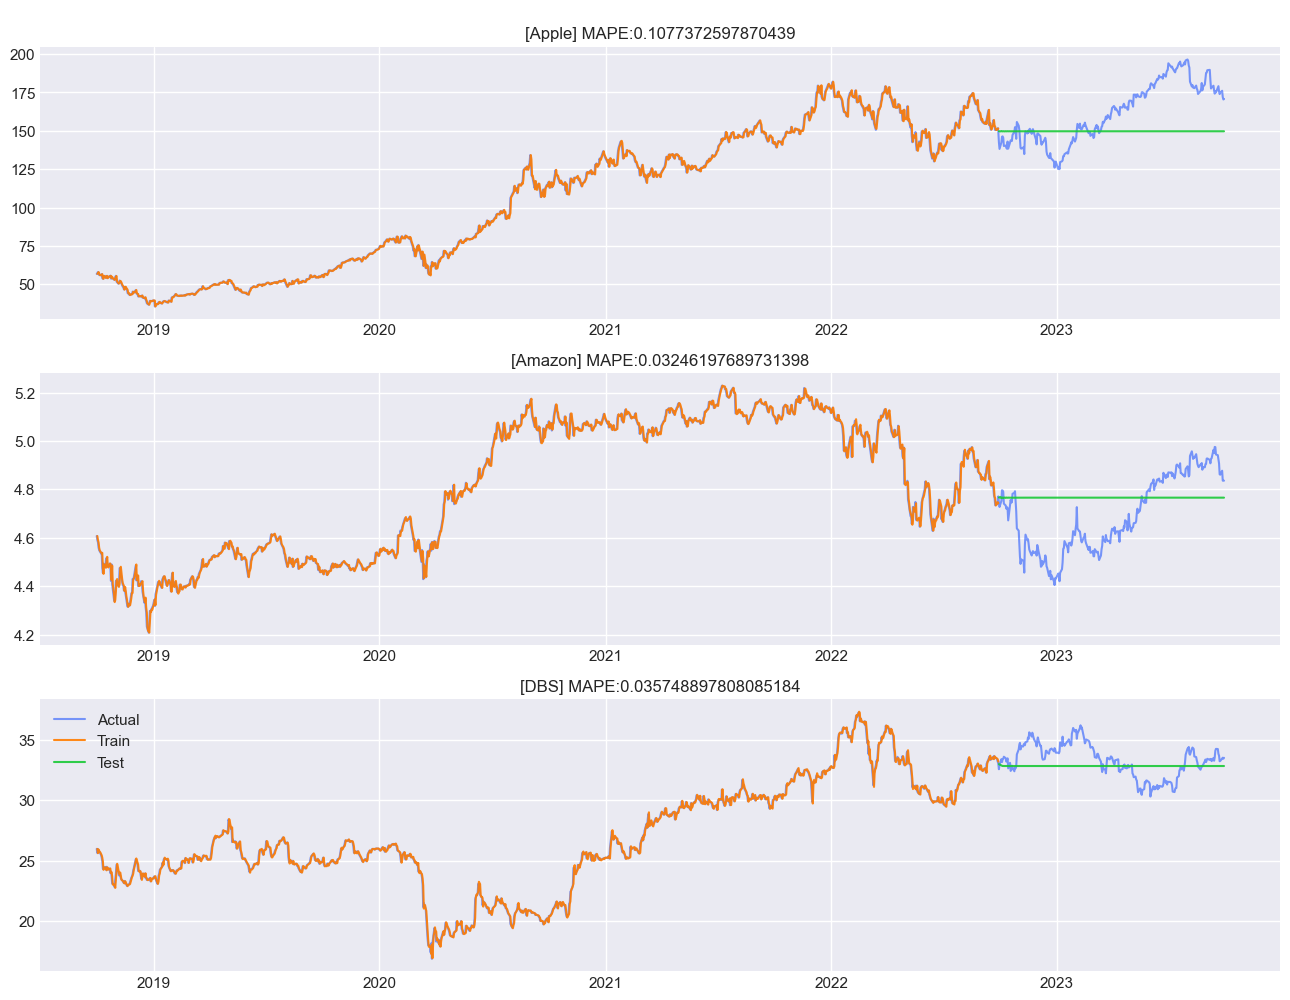

In [212]:
orders = [(7,1,5),(4,1,9),(0,1,8)]

fig, axes = plt.subplots(3,1, figsize=(16, 12))

for idx, order in enumerate(orders):
    mod = ARIMA(train_data[df.columns[idx]], order = order)
    res = mod.fit()

    full_pred = res.predict()
    pred = res.forecast(365)

    axes[idx].set_title("\n[{}] MAPE:{}".format(df.columns[idx], mean_absolute_percentage_error(test_data[df.columns[idx]],pred)))
    axes[idx].plot(df[df.columns[idx]], label = 'Actual', alpha=0.5)
    axes[idx].plot(full_pred.iloc[1:], label = 'Train', alpha=0.9)
    axes[idx].plot(pred, label='Test', alpha=0.9)
plt.legend()
plt.show()

In [23]:
sarima_apple_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Apple"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_apple_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_apple_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)


36it [10:44, 17.92s/it]


,rmse,mape,aic
"(3,1,2),(1,1,2,7)",14.702841,0.100119,2401.567678
"(3,1,2),(2,1,2,7)",15.119687,0.103436,2402.622842
"(3,1,2),(1,1,1,7)",16.576792,0.116359,2399.437625
"(3,1,2),(2,1,1,7)",17.091308,0.121649,2401.172831
"(2,1,3),(1,1,2,7)",18.147967,0.137138,2402.661405
"(1,1,1),(1,1,1,7)",18.186134,0.137355,2397.019018
"(3,1,1),(1,1,2,7)",18.205881,0.137417,2400.691078
"(2,1,3),(2,1,2,7)",18.216266,0.137432,2404.107707
"(3,1,1),(2,1,1,7)",18.184937,0.137490,2401.130189
"(2,1,1),(2,1,2,7)",18.232739,0.137579,2399.791936


In [24]:
sarima_amazon_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["Amazon"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_amazon_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_amazon_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [09:51, 16.43s/it]


,rmse,mape,aic
"(2,1,1),(2,1,1,7)",0.258686,0.041398,-3883.682356
"(3,1,2),(2,1,2,7)",0.269022,0.043032,-3882.966287
"(2,1,3),(1,1,1,7)",0.273591,0.044135,-3881.703967
"(1,1,2),(2,1,2,7)",0.277990,0.044821,-3884.682677
"(2,1,2),(2,1,2,7)",0.279329,0.045069,-3883.576018
"(2,1,2),(2,1,1,7)",0.279911,0.045108,-3888.989367
"(1,1,2),(2,1,1,7)",0.280868,0.045325,-3889.456117
"(3,1,3),(2,1,2,7)",0.281436,0.045418,-3878.648113
"(3,1,1),(1,1,1,7)",0.281577,0.045513,-3887.363888
"(2,1,1),(1,1,1,7)",0.281954,0.045599,-3886.025033


In [25]:
sarima_dbs_results = dict()

# Define Params Space
p_range = range(1,4)
d_range = [1]
q_range = range(1,4)
P_range = range(1,3)
D_range = [1]
Q_range = range(1,3)
m = [7]

for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
    try:
        rmse_mape_aic_tuple = expanding_window(SARIMAX, train_data["DBS"], order = (p,d,q), seasonal_order=(P,D,Q,m))
        sarima_dbs_results[f'({p},{d},{q}),({P},{D},{Q},{m})'] = rmse_mape_aic_tuple
    except:
        continue

pd.DataFrame(sarima_dbs_results, index=['rmse','mape' ,'aic']).T.sort_values(['mape']).head(10)

36it [10:12, 17.01s/it]


,rmse,mape,aic
"(2,1,3),(1,1,2,7)",4.915769,0.157126,20.550153
"(1,1,1),(1,1,2,7)",4.919508,0.157212,21.430131
"(3,1,3),(1,1,2,7)",4.923638,0.157474,18.926945
"(3,1,3),(1,1,1,7)",4.926112,0.157646,13.997146
"(3,1,1),(1,1,2,7)",4.928663,0.157702,20.150010
"(2,1,1),(1,1,2,7)",4.928465,0.157711,18.407641
"(2,1,3),(1,1,1,7)",4.928352,0.157714,14.354898
"(1,1,1),(1,1,1,7)",4.930541,0.157764,15.365486
"(2,1,2),(1,1,2,7)",4.931744,0.157772,20.027585
"(1,1,3),(1,1,2,7)",4.935779,0.157916,19.673134
